In [47]:
from statsmodels.graphics.tsaplots import plot_acf
import sys
import numpy as np
sys.path.append('../')
sys.path.append('../rlkit_master/')
from rlkit_master.rlkit.samplers.rollout_functions import rollout
import torch
from gym.envs.mujoco import HalfCheetahEnv
from rlkit_master.rlkit.envs.wrappers import NormalizedBoxEnv
from skimage import util
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from math import sqrt

In [31]:
eval_env = NormalizedBoxEnv(HalfCheetahEnv())
exp_name = 'name-of-experiment_2020_01_10_23_16_20_0000--s-0'

In [32]:
def get_action_mean_ft_spectrum_from_epoch(exp_name,act_num,epoch_num):
    agent = torch.load(f'../rlkit_master/data/name-of-experiment/{exp_name}/itr_{epoch_num}.pkl')
    agent = agent['trainer/policy']

    rollout_dict = rollout(
    env = eval_env ,
    agent = agent,
    max_path_length=1000,
    render=False,
    render_kwargs=None,
        )

    M = int(10*8)
    slices = util.view_as_windows(rollout_dict['actions'][:,act_num], window_shape=(M,), step=6)
    # remove DC
    slices -= np.mean(slices)
    
    win = np.hanning(M + 1)[:-1]
    slices = slices * win

    spectrum = np.fft.rfft(slices.T, axis=0, norm="ortho")
    return (np.abs(spectrum).mean(axis = 1))

In [33]:
act_num = 5
x1 = 0
x2 = 41
x = np.arange(x1,x2)

# x = np.linspace(0, 10, 500)
max_steps = 4990
y_dict ={}
for act in range(6):
    for epoch in range(0,max_steps,10):
        y_dict[f'{act}_{epoch}'] = get_action_mean_ft_spectrum_from_epoch(exp_name,act,epoch)
y_dict["y"] = y_dict['0_0']

y_dict['x'] = x

In [36]:
# y_dict.keys()

In [37]:
# Plot aoutocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf
epoch_num = 4980#560  2530
act_num = 2#2
# name-of-experiment_2020_01_06_15_38_29_0000--s-0
exp_name = 'name-of-experiment_2020_01_10_23_16_20_0000--s-0'
# 'name-of-experiment_2020_01_10_23_16_20_0000--s-0'
agent = torch.load(f'../rlkit_master/data/name-of-experiment/{exp_name}/itr_{epoch_num}.pkl')
agent = agent['trainer/policy']

rollout_dict = rollout(
env = eval_env ,
agent = agent,
max_path_length=1000,
render=False,
render_kwargs=None,
    )

period = np.argmax(y_dict[f'{act_num}_{epoch_num}'])
actions = rollout_dict['actions'][:,act_num]
period

13

Using matplotlib backend: TkAgg


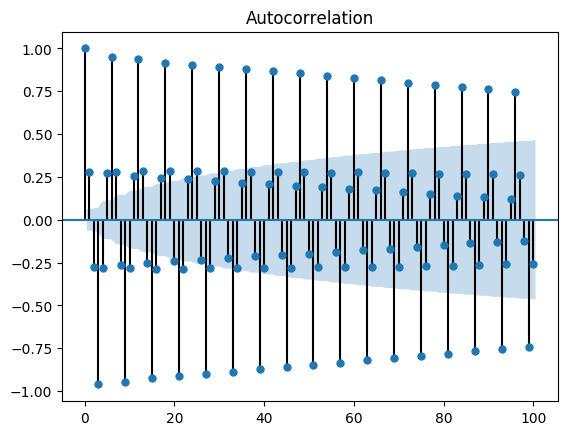

In [38]:
%matplotlib
# plt.xlim = (50,200)

plot_acf(actions,lags=100)

In [42]:
shift = 6
plt.figure(figsize=(16, 6))
plt.plot(actions[50:150])
# plt.plot(actions[13550+13])
plt.plot(actions[50+shift:150+shift])
plt.show()

In [48]:
# check period
min_rmse = 10
for period in range(1,50):
    rmse = sqrt(mean_squared_error(actions[:-period], actions[period:]))
    print('period =', period )
    print(rmse)
    if rmse < min_rmse:
        min_rmse = rmse
        min_period = period
        
min_period, min_rmse

period = 1
1.0398396045536265
period = 2
1.384357042389901
period = 3
1.7160343564246636
period = 4
1.3867824486085323
period = 5
1.044252612683528
period = 6
0.2511385235513099
period = 7
1.0392451305078025
period = 8
1.3792475205123103
period = 9
1.7112141564058727
period = 10
1.388333049917631
period = 11
1.053574377337525
period = 12
0.2844261595012417
period = 13
1.0353883878861745
period = 14
1.3726796599266142
period = 15
1.706156351502791
period = 16
1.3911600262389088
period = 17
1.0621144773382465
period = 18
0.3199886452627287
period = 19
1.0326951622496592
period = 20
1.3681075569807941
period = 21
1.7018659645090077
period = 22
1.3924860127977596
period = 23
1.0672025397429208
period = 24
0.33641397707401594
period = 25
1.032063250222445
period = 26
1.3641622150762527
period = 27
1.6997023321852238
period = 28
1.3928568214723545
period = 29
1.0724903420144605
period = 30
0.3519788501919086
period = 31
1.0319950995513723
period = 32
1.3599955140067894
period = 33
1.69609326

(6, 0.2511385235513099)